# Effective PWV on a Black Body

The effective precipitable water vapor is defined as a rescaling of the precipitable water vapor (PWV) along the the line of sight such that changes in the brightness of an object become (roughly) linear. This notebook demonstrates the definition of effective PWV by plotting the PWV induced change in the magnitude of a Black Body.


In [1]:
import sys
from pathlib import Path

sys.path.insert(0, '../')

import numpy as np
import snat_sim
import sncosmo
from astropy.modeling import models
from astropy import units as u
from matplotlib import pyplot as plt
from pwv_kpno.defaults import v1_transmission


In [2]:
fig_dir = Path('.') / 'figs'
fig_dir.mkdir(exist_ok=True, parents=True)


In [3]:
def black_body_sed(temp, wavelengths, pwv, res=5):
    """Simulate a black body spectrum with PWV effects
    
    Args:
        temp        (float): Temperature of the black body in Kelvin
        wavelengths (array): Wavelengths to simulate the SED at
        pwv         (float): PWV concentration to apply
        res         (float): Resolution to sample the atmosphere with
        
    Returns:
        An array of flux values
    """
    
    bb = models.BlackBody(temperature=temp * u.K)
    flux_without_atm = bb(wavelengths * u.AA)  
    transmission = v1_transmission(pwv, wavelengths, res)
    return flux_without_atm * transmission


def calc_delta_bb_mag(pwv_vals, band, bb_temp=8000):
    """Calculate the PWV induced change in magnitude for a black body

    Args:
        pwv_vals (array): The pwv values to plot saturation for
        band  (Bandpass): SNCosmo bandpass
        bb_temp  (float): Temperature of the black body to use

    Returns:
        A list of delta magnitudes in the given band
    """

    wave = np.arange(band.minwave(), band.maxwave(), .05)
    base_sed = black_body_sed(bb_temp, wave, pwv=0)
    base_mag = -2.5 * np.log(np.trapz(y=base_sed * wave, x=wave))

    delta_mag = []
    for pwv in pwv_vals:
        sed_with_pwv = black_body_sed(bb_temp, wave, pwv)
        pwv_mag = -2.5 * np.log(np.trapz(y=sed_with_pwv * wave, x=wave))
        delta_mag.append(pwv_mag - base_mag)

    return delta_mag


In [4]:
def plot_delta_bb_mag(pwv_los, pwv_los_labels, exp=0.6, norm_pwv= 2, fid_pwv=4):
    """Plot the PWV induced change in magnitude for a black body

    Plot relative to LOS and effective PWV

    Args:
        pwv_los        (array): PWV values along line of sight
        pwv_los_labels (array): Axis labels for line of sight PWV
        exp            (float): Exponent for calculating PWV_eff from PWV_los
        norm_pwv       (float): PWV value used to determine ``coef``
        fid_pwv        (float): Fiducial PWV used in the paper
    """

    coef = 1 / (norm_pwv ** exp)

    # Convert PWV line-of-sight into PWV effective
    pwv_eff = coef * (pwv_los ** exp)
    pwv_eff_labels = coef * (pwv_los_labels ** exp)

    # Create axes for plotting vs los and effective pwv
    fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    left_twin_y = left_ax.twiny()
    right_twin_y = right_ax.twiny()

    # Manually set axis limits to avoid wrestling with the auto scaling later on
    los_xlim = pwv_los_labels.min(), pwv_los_labels.max()

    left_twin_y.set_xlim(los_xlim)
    left_twin_y.set_xticks(pwv_los_labels)
    left_twin_y.set_xticklabels(pwv_los_labels)

    eff_xlim = pwv_eff_labels.min(), pwv_eff_labels.max()
    right_ax.set_xlim(eff_xlim)

    right_twin_y.set_xlim(eff_xlim)
    right_twin_y.set_xticks(pwv_eff_labels)
    right_twin_y.set_xticklabels(pwv_los_labels)

    # Plot delta mag for each band
    for band_abbrev in 'rizy':
        band_name = f'lsst_hardware_{band_abbrev}'
        band = sncosmo.get_bandpass(band_name)
        delta_mag = calc_delta_bb_mag(pwv_los, band)

        left_twin_y.plot(pwv_los, delta_mag)
        right_ax.plot(pwv_eff, delta_mag, label=f'LSST {band_abbrev}')

    # Plot reference lines for pwv values
    left_twin_y.axvline(norm_pwv, linestyle=':', color='k', alpha=.85, label='Norm pwv')
    left_twin_y.axvline(fid_pwv, linestyle='-.', color='k', alpha=.7, label='Fiducial pwv')
    right_twin_y.axvline(coef * (norm_pwv ** exp), linestyle=':', color='k', alpha=.85)
    right_twin_y.axvline(coef * (fid_pwv ** exp), linestyle='-.', color='k', alpha=.7)

    eff_ticks = np.arange(0, max(pwv_eff_labels) + 1, .5)
    los_ticks = (eff_ticks / coef) ** (1/exp)
    left_ax.set_xticks(los_ticks)
    left_ax.set_xticklabels(eff_ticks)
    left_ax.set_xlim(los_xlim)

    # A final bit of formatting
    left_ax.set_ylabel(r'$\Delta$ mag')
    left_ax.set_xlabel(r'PWV$_{eff}$')
    left_twin_y.set_xlabel(r'PWV$_{los}$')
    right_ax.set_xlabel(r'PWV$_{eff}$')
    right_twin_y.set_xlabel(r'PWV$_{los}$')
    left_twin_y.legend(loc='upper left', framealpha=1)
    right_ax.legend(loc='upper left', framealpha=1)

    left_ax.set_ylim(ymin=0)
    plt.tight_layout()


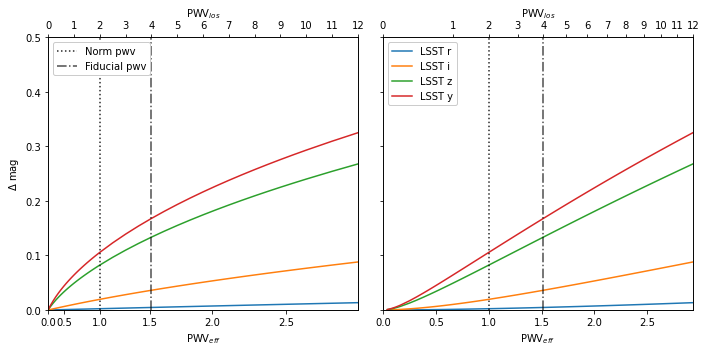

In [5]:
# Sample PWV values more frequently at lower values for a smoother curve
pwv = np.concatenate([
    np.arange(0.01, .1, .01),
    np.arange(.1, 2, .1),
    np.arange(2, 10, .5),
    np.arange(10, 12.1, 1)
])

pwv_labels = np.arange(0, 13)
plot_delta_bb_mag(pwv, pwv_labels)
plt.ylim(0, .5)
plt.savefig(fig_dir / f'delta_bb_mag.png')
plt.show()
